This notebook illustrates taking successive cuts on the data and plotting the resulting hit distributions after the cuts. The cuts are made along the x-axis at stations 1, 2, and 4 in the detector pairs H1B/T, H2B/T, and H4B/T respectively. The H1XY plots show the hits/event after the station 1 cut is performed, the H2XY plots show the hits/event after both station 1 and station 2 cuts are performed, and the H4XY plots show the hits/event after all four cuts are performed. 

Normalization is achieved by taking the total number of hits in all events meeting the given criteria and dividing by the number of valid events remaining after the cuts were imposed. To ensure proper readings, the weights are divided by 2 on all station 4 plots, since detectors in these stations count two hits for every one real hit. 

# Imports

In [2]:
import uproot4   # concatenate bkg data
import uproot
import awkward1 as ak
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import                                                                                                                  
import mplhep as hep
plt.style.use(hep.style.ROOT)

# Files

Background Data

In [7]:
root = uproot4.concatenate("../../../../2017Data/combined_data/track_*.root:save/rawEvent",["fTriggerBits","fAllHits.pos","fAllHits.driftDistance","fAllHits.detectorID"],library="ak",how="zip")

Signal Data

In [8]:
Brem003 = "../../../../electrons/sim_eval_Brem_0.033428_z500_600_eps_-5.2.root"
Brem047 = "../../../../electrons/sim_eval_Brem_0.470915_z500_600_eps_-6.root"
Eta001 = "../../../../electrons/sim_eval_Eta_0.019564_z500_600_eps_-5.2.root"
Eta054 = "../../../../electrons/sim_eval_Eta_0.540000_z500_600_eps_-6.root"

In [10]:
Brem003.split("_")[3]

'0.033428'

# Get Background Data

In [26]:
def get_BackgroundData(root):
    bg_events = ak.zip({"Hits":ak.zip({
                                        "detectorID": root.fAllHits["detectorID"],
                                        "pos": root.fAllHits["pos"]
                                      })
                       }, depth_limit=1)
    return bg_events

def H1BT(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 31) & (arr.detectorID <= 32)
    else:
        mask = (arr.detID >= 31) & (arr.detID <= 32)
    return mask

def H1LR(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 33) & (arr.detectorID <= 34)
    else:
        mask = (arr.detID >= 33) & (arr.detID <= 34)
    return mask

def H2BT(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 37) & (arr.detectorID <= 38)
    else:
        mask = (arr.detID >= 37) & (arr.detID <= 37)
    return mask

def H2LR(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 35) & (arr.detectorID <= 36)
    else:
        mask = (arr.detID >= 35) & (arr.detID <= 36)
    return mask

def H4BT(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 45) & (arr.detectorID <= 46)
    else:
        mask = (arr.detID >= 45) & (arr.detID <= 46)
    return mask

def H4Y1LR(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 41) & (arr.detectorID <= 42)
    else:
        mask = (arr.detID >= 41) & (arr.detID <= 42)
    return mask

def H4Y2LR(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 43) & (arr.detectorID <= 44)
    else:
        mask = (arr.detID >= 43) & (arr.detID <= 44)
    return mask

def layer4_BG(root,pos1=-10,pos2=10,pos3=-10,pos4=10,pos5=-10,pos6=10):
    '''impose cuts on BG data'''
    # get all events
    allHits = get_BackgroundData(root)["Hits"]
    # get all valid events based on TriggerBits criteria (random trigger)
    validEvent_fTriggerBits = (root.fTriggerBits==65) | (root.fTriggerBits==67)
    # now mask all events by TriggerBits
    hitsBG = allHits[validEvent_fTriggerBits]
    
    # cut on station 1
    h1_mask = H1BT(hitsBG)
    h1_hits = hitsBG[h1_mask]
    x1_mask = (h1_hits.pos >= pos1) & (h1_hits.pos <= pos2)
    x1_index = np.where(ak.any(x1_mask,axis=1))   # indices of all events meeting st1 criteria
    n1 = len(ak.flatten(x1_index))   # number of valid events after cut 1
    
    # cut on station 2
    h2_mask = H2BT(hitsBG)
    h2_hits = hitsBG[h2_mask]
    x2_mask = (h2_hits.pos >= pos3) & (h2_hits.pos <= pos4)
    x2_index = np.where(ak.any(x2_mask,axis=1))   # indices of all events meeting st2 criteria
    # get indices of events meeting st1 AND st2 criteria
    x1x2_index = np.intersect1d(x1_index,x2_index)   # we use this to plot H2BT/H2LR
    n2 = len(x1x2_index)   # number of valid events after cut1 and cut2
    
    # debugging
    '''
    print(h2_mask)
    print(np.sum(h2_mask))
    print(x2_mask)
    print(x2_index)
    print(np.sum(x2_index))
    print(x1x2_index)
    '''
    
    # cut on station 4
    h4_mask = H4BT(hitsBG)
    h4_hits = hitsBG[h4_mask]
    x4_mask = (h4_hits.pos >= pos5) & (h4_hits.pos <= pos6)
    x4_index = np.where(ak.any(x4_mask,axis=1))
    # get indices of valid events meeting all 3 criteria
    final_index = np.intersect1d(x1x2_index,x4_index)    # we use this to plot H4s
    n4 = len(final_index)
    
    # get L/R hodos
    h1lr = H1LR(hitsBG)
    h2lr = H2LR(hitsBG)
    h4y1lr = H4Y1LR(hitsBG)
    h4y2lr = H4Y2LR(hitsBG)
    
    h1lr_hits = hitsBG[h1lr]
    h2lr_hits = hitsBG[h2lr]
    h4y1lr_hits = hitsBG[h4y1lr]
    h4y2lr_hits = hitsBG[h4y2lr]
    
    # now use the appropriate x?_index array to get the valid entries 
    # return a list of each detector [uncut,cut,nevents_cut] -> needs to be flattened
    return [[h1_hits.pos,h1_hits[x1_index].pos,n1],         # H1Bt
            [h2_hits.pos,h2_hits[x1x2_index].pos,n2],       # H2BT
            [h4_hits.pos,h4_hits[x4_mask].pos,n4],          # H4BT
            [h1lr_hits.pos,h1lr_hits[x1_index].pos,n1],     # H1LR
            [h2lr_hits.pos,h2lr_hits[x1x2_index].pos,n2],   # H2LR
            [h4y1lr_hits.pos,h4y1lr_hits[x4_index].pos,n4], # H4Y1LR
            [h4y2lr_hits.pos,h4y2lr_hits[x4_index].pos,n4]] # H4Y2LR


def plotBG(hists, weighted=False):
    '''use to plot only Background data with cuts'''
    bins_range = [(46, (-162.008,162.008), "H1BT"),
                  (32, (-203.38,203.38), "H2BT"),
                  (32, (-304.518,304.518), "H4BT"),
                  (40, (-140.117,140.117), "H1LR"),
                  (38, (-241.285,241.285), "H2LR"),
                  (32, (-365.797,365.797), "H4Y1LR"),
                  (32, (-365.797,365.797), "H4Y2LR")]
    
    for i in range(len(hists)):
        # weighting
        if (weighted==True):
            ws_uncut = np.ones_like(ak.to_numpy(ak.flatten(hists[i][0])))/677   # hard code (number of valid events after fTriggerBits selection)
            ws_cut = np.ones_like(ak.to_numpy(ak.flatten(hists[i][1])))/hists[i][2]
            if (i==2) or (i==5) or (i==6):
                ws_uncut /= 2
                ws_cut /= 2
        plt.clf()
        if (weighted==True):
            plt.hist(ak.flatten(hists[i][0]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="uncut",weights=ws_uncut)
            plt.hist(ak.flatten(hists[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="cut",weights=ws_cut)
            plt.ylabel("Hits/Event")
            plt.title("Hits/Event in {}".format(bins_range[i][2]))
        else:
            plt.hist(ak.flatten(hists[i][0]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="uncut")
            plt.hist(ak.flatten(hists[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="cut")
            plt.ylabel("Total Hits")
            plt.title("Total Hits in {}".format(bins_range[i][2]))
        if (i<3):
            plt.xlabel("x [cm]")
        else:
            plt.xlabel("y [cm]")
        plt.legend()
        plt.show()

# Get Signal Data

In [14]:
# Thank you Cristina!
def getDataSim(fname="", procName="Truth"):
    dq_dict = uproot.open(fname)["Truth"]
    dq_events = ak.zip({"Hits":ak.zip({
                                      "detID":   dq_dict["hit_detID"].array(),
                                      "edep":    dq_dict["hit_edep"].array(),
                                      "elmID":   dq_dict["hit_elmID"].array(),
                                      "truthx":  dq_dict["hit_truthx"].array(),
                                      "truthy":  dq_dict["hit_truthy"].array(),
                                      "truthz":  dq_dict["hit_truthz"].array(),
                                      })
                        }, depth_limit=1)
    
    return dq_events

def layer4Sim(root,pos1=-10,pos2=10,pos3=-10,pos4=10,pos5=-10,pos6=10):
    hits = getDataSim(root)["Hits"]
    
    h1_mask = H1BT(hits,data="signal")
    h1_hits = hits[h1_mask]
    x1_mask = (h1_hits.truthx >= pos1) & (h1_hits.truthx <= pos2)
    x1_index = np.where(ak.any(x1_mask,axis=1))
    nvalid1 = len(ak.flatten(x1_index))   # number of valid events after cut 1
    
    h2_mask = H2BT(hits,data="signal")
    h2_hits = hits[h2_mask]
    x2_mask = (h2_hits.truthx >= pos3) & (h2_hits.truthx <= pos4)
    x2_index = np.where(ak.any(x2_mask,axis=1))
    # get indices of valid events meeting all criteria
    indices = np.intersect1d(x1_index,x2_index)
    nvalid2 = len(indices)
    
    h4_mask = H4BT(hits,data="signal")
    h4_hits = hits[h4_mask]
    x4_mask = (h4_hits.truthx >= pos5) & (h4_hits.truthx <= pos6)
    x4_index = np.where(ak.any(x4_mask,axis=1))
    # get indices of valid events meeting all criteria
    valid = np.intersect1d(indices,x4_index)
    nvalid4 = len(valid)
    
    # get the LR hodos
    h1lr = H1LR(hits,data="signal")
    h2lr = H2LR(hits,data="signal")
    h4y1lr = H4Y1LR(hits,data="signal")
    h4y2lr = H4Y2LR(hits,data="signal")
    
    h1lr_hits = hits[h1lr]
    h2lr_hits = hits[h2lr]
    h4y1lr_hits = hits[h4y1lr]
    h4y2lr_hits = hits[h4y2lr]
    
    # now use the appropriate x?_index array to get the valid entries 
    # return a list of each detector [uncut,cut,nevents_cut] -> needs to be flattened
    return [[h1_hits.truthx,h1_hits[x1_index].truthx,nvalid1],         # H1Bt
            [h2_hits.truthx,h2_hits[indices].truthx,nvalid2],          # H2BT
            [h4_hits.truthx,h4_hits[x4_mask].truthx,nvalid4],          # H4BT
            [h1lr_hits.truthy,h1lr_hits[x1_index].truthy,nvalid1],     # H1LR
            [h2lr_hits.truthy,h2lr_hits[indices].truthy,nvalid2],     # H2LR
            [h4y1lr_hits.truthy,h4y1lr_hits[x4_index].truthy,nvalid4], # H4Y1LR
            [h4y2lr_hits.truthy,h4y2lr_hits[x4_index].truthy,nvalid4]] # H4Y2LR

def plot_Sim(hists, weighted=False):
    '''Use to plot only simulation data w/ cuts'''
    bins_range = [(46, (-162.008,162.008), "H1BT"),
                  (32, (-203.38,203.38), "H2BT"),
                  (32, (-304.518,304.518), "H4BT"),
                  (40, (-140.117,140.117), "H1LR"),
                  (38, (-241.285,241.285), "H2LR"),
                  (32, (-365.797,365.797), "H4Y1LR"),
                  (32, (-365.797,365.797), "H4Y2LR")]

    for i in range(len(hists)):
        # weighting
        if (weighted==True):
            ws_uncut = np.ones_like(ak.to_numpy(ak.flatten(hists[i][0])))/10000   # hard code (10,000 sim evts)
            ws_cut = np.ones_like(ak.to_numpy(ak.flatten(hists[i][1])))/hists[i][2]
            if (i==2) or (i==5) or (i==6):
                ws_uncut /= 2
                ws_cut /= 2
        plt.clf()
        if (weighted==True):
            plt.hist(ak.flatten(hists[i][0]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="uncut",weights=ws_uncut)
            plt.hist(ak.flatten(hists[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="cut",weights=ws_cut)
            plt.ylabel("Hits/Event")
            plt.title("Hits/Event in {}".format(bins_range[i][2]))
        else:
            plt.hist(ak.flatten(hists[i][0]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="uncut")
            plt.hist(ak.flatten(hists[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="cut")
            plt.ylabel("Total Hits")
            plt.title("Total Hits in {}".format(bins_range[i][1]))
        if (i<3):
            plt.xlabel("x [cm]")
        else:
            plt.xlabel("y [cm]")
        plt.legend()
        plt.show()

# Comparing signal to background after cuts

In [19]:
Eta054.split("_")[3][0:4] + "MeV"

'0.54MeV'

In [20]:
Eta054

'../../../../electrons/sim_eval_Eta_0.540000_z500_600_eps_-6.root'

In [22]:
Eta054.split("_")[2]

'Eta'

In [31]:
def plot_overlay(bg, sim, name, sim2=False, name2=False, weighted=False):
    '''
    bg, sim are the respective histogram lists generated by layer4_ function
    '''
    # get process names and masses
    mass = name.split("_")[3][0:4] + " MeV"
    proc = name.split("_")[2]
    if (sim2 != False):
        mass2 = name2.split("_")[3][0:4] + " MeV"
        proc2 = name2.split("_")[2]
        
    bins_range = [(46, (-162.008,162.008), "H1BT"),
                  (32, (-203.38,203.38), "H2BT"),
                  (32, (-304.518,304.518), "H4BT"),
                  (40, (-140.117,140.117), "H1LR"),
                  (38, (-241.285,241.285), "H2LR"),
                  (32, (-365.797,365.797), "H4Y1LR"),
                  (32, (-365.797,365.797), "H4Y2LR")]
    
    # the histogram lists are both in the form:
    # [uncut, cut, nevents] (nevents = number of valid events after st4 cut)
    for i in range(7):
        # weighting
        if (weighted==True):
            ws_bg = np.ones_like(ak.to_numpy(ak.flatten(bg[i][1])))/bg[i][2]
            ws_sim = np.ones_like(ak.to_numpy(ak.flatten(sim[i][1])))/sim[i][2]
            if (i==2) or (i==5) or (i==6):
                ws_bg /= 2
                ws_sim /= 2
            if (sim2 != False):
                ws_sim2 = np.ones_like(ak.to_numpy(ak.flatten(sim2[i][1])))/sim2[i][2]
                if (i==2) or (i==5) or (i==6):
                    ws_sim2 /= 2
        
        plt.clf()
        if (weighted==True):
            plt.hist(ak.flatten(bg[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="data",weights=ws_bg)
            plt.hist(ak.flatten(sim[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label=mass,weights=ws_sim)
            plt.ylabel("Hits/Event")
            plt.title("Hits/Event in {} ({})".format(bins_range[i][2],proc))
            if (sim2 != False):
                plt.hist(ak.flatten(sim2[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label=mass2,weights=ws_sim2)    
            
        else:
            plt.hist(ak.flatten(bg[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="data")
            plt.hist(ak.flatten(sim[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label=mass)
            plt.ylabel("Total Hits")
            plt.title("Total Hits in {} ({})".format(bins_range[i][2],proc))
            if (sim2 != False):
                plt.hist(ak.flatten(sim2[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label=mass2,weights=ws_sim2)
        if (i<3):
            plt.xlabel("x [cm]")
        else:
            plt.xlabel("y [cm]")
        plt.legend()
        #plt.savefig("{}_{}".format(bins_range[i][2],proc))
        plt.show()

**Plot**

In [27]:
bg = layer4_BG(root,pos1=-15,pos2=15,pos3=-15,pos4=15,pos5=-15,pos6=15)
sim = layer4Sim(Eta054,pos1=-15,pos2=15,pos3=-15,pos4=15,pos5=-15,pos6=15)
sim2 = layer4Sim(Eta001,pos1=-15,pos2=15,pos3=-15,pos4=15,pos5=-15,pos6=15)

/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/awkward1/_connect/_numpy.py:99: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(ufunc, method)(
/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/awkward1/_connect/_numpy.py:99: RuntimeWarning: invalid value encountered in less_equal
  result = getattr(ufunc, method)(


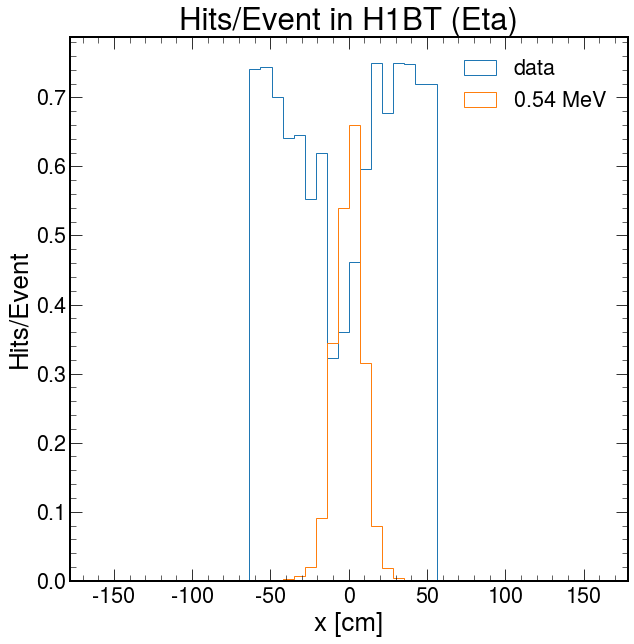

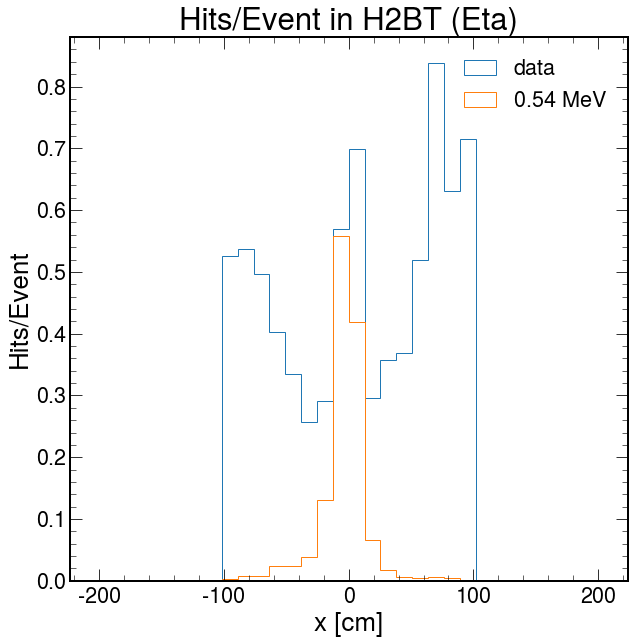

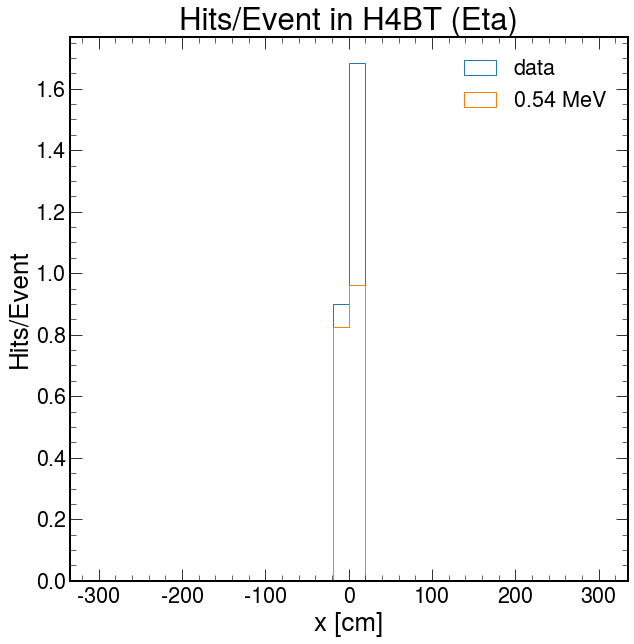

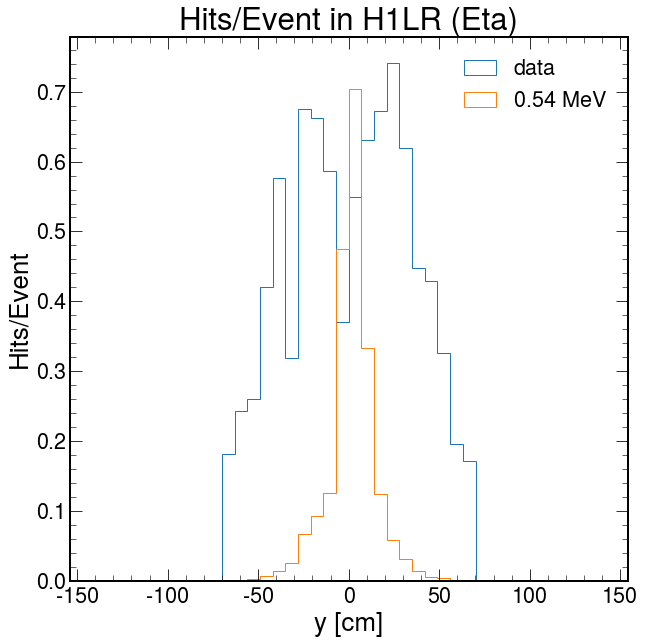

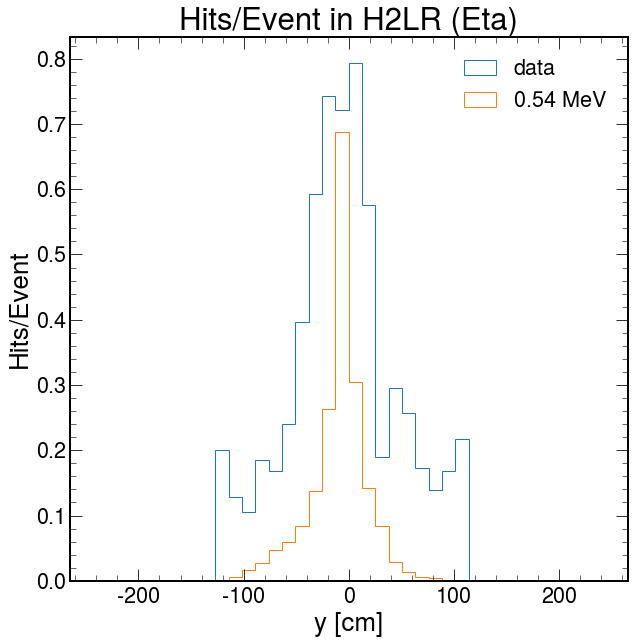

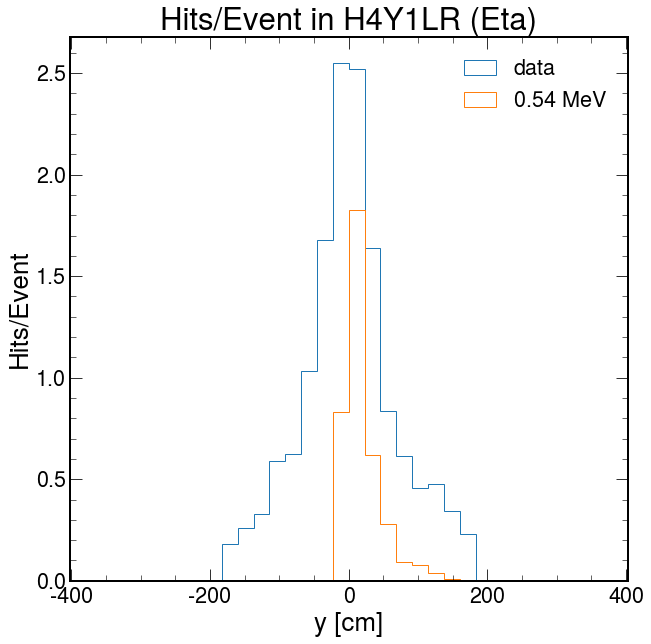

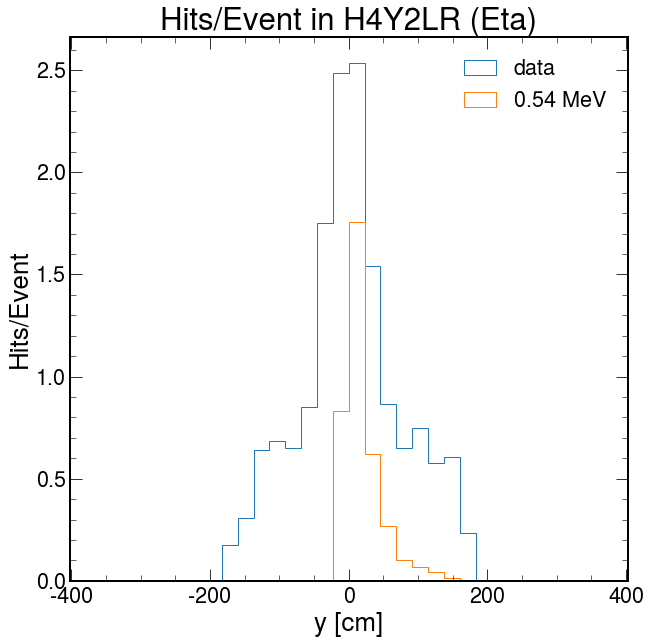

In [32]:
plot_overlay(bg,sim,name=Eta054,weighted=True)